In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy.sparse import hstack

from xgboost import XGBRegressor


In [6]:
df=pd.read_csv('it_job_descriptions_cleaned.csv')
df=df.drop(columns=['combined','gender'])

In [7]:
df.head()

,experience,qualification,work_type,job_title,role,job_description,skills,responsibilities,salary_avg
0,4.0,B.Tech,Contract,Data Analyst,Data Scientist,Data Scientists use their expertise in data an...,Machine learning algorithms and libraries (e.g...,Apply machine learning algorithms and statisti...,87000.0
1,5.0,MCA,Temporary,Data Analyst,Data Scientist,Data Scientists use their expertise in data an...,Machine learning algorithms and libraries (e.g...,Apply machine learning algorithms and statisti...,90500.0
2,3.0,BBA,Contract,Data Analyst,Business Intelligence Analyst,Business Intelligence Analysts gather and anal...,"Data analysis and visualization tools (e.g., T...",Gather and analyze data to provide insights fo...,81000.0
3,4.0,BA,Full-Time,Data Analyst,Data Scientist,Data Scientists use their expertise in data an...,Machine learning algorithms and libraries (e.g...,Apply machine learning algorithms and statisti...,88000.0
4,3.0,MBA,Intern,Data Analyst,Business Intelligence Analyst,Business Intelligence Analysts gather and anal...,"Data analysis and visualization tools (e.g., T...",Gather and analyze data to provide insights fo...,95500.0


In [8]:
df.describe()

,experience,salary_avg
count,101397.000000,101397.000000
mean,2.503881,82482.129649
std,1.707419,7515.167785
min,0.000000,67500.000000
25%,1.000000,76000.000000
50%,3.000000,82500.000000
75%,4.000000,89000.000000
max,5.000000,97500.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101397 entries, 0 to 101396
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   experience        101397 non-null  float64
 1   qualification     101397 non-null  object 
 2   work_type         101397 non-null  object 
 3   job_title         101397 non-null  object 
 4   role              101397 non-null  object 
 5   job_description   101397 non-null  object 
 6   skills            101397 non-null  object 
 7   responsibilities  101397 non-null  object 
 8   salary_avg        101397 non-null  float64
dtypes: float64(2), object(7)
memory usage: 7.0+ MB


In [10]:
df["salary_avg"] = np.log1p(df["salary_avg"])
df["text"] = (
    df["job_description"].fillna("") + " " +
    df["skills"].fillna("") + " " +
    df["responsibilities"].fillna("")
)

In [11]:
numerical_cols = ["experience"]

categorical_cols = [
    "qualification",
    "work_type",
    "job_title",
    "role"
]

target = "salary_avg"


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    df, df[target],
    test_size=0.2,
    random_state=42
)


In [13]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

X_train_cat = ohe.fit_transform(X_train[categorical_cols])
X_val_cat = ohe.transform(X_val[categorical_cols])


In [14]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_text = tfidf.fit_transform(X_train["text"])
X_val_text = tfidf.transform(X_val["text"])


In [15]:
X_train_num = X_train[numerical_cols].values
X_val_num = X_val[numerical_cols].values


In [16]:
from scipy.sparse import csr_matrix

X_train_num = csr_matrix(X_train_num)
X_val_num = csr_matrix(X_val_num)


In [17]:
X_train_final = hstack([X_train_num, X_train_cat, X_train_text])
X_val_final = hstack([X_val_num, X_val_cat, X_val_text])


In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_final, label=y_train)
dval = xgb.DMatrix(X_val_final, label=y_val)

params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "eval_metric": "rmse"
}

evals = [(dtrain, "train"), (dval, "eval")]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=175,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=True
)

# Predict
preds = bst.predict(dval)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

preds_salary = np.expm1(preds)
y_val_salary = np.expm1(y_val)

rmse = np.sqrt(mean_squared_error(y_val_salary, preds_salary))
mae = mean_absolute_error(y_val_salary, preds_salary)
r2 = r2_score(y_val_salary, preds_salary)
mape = np.mean(np.abs((y_val_salary - preds_salary) / y_val_salary)) * 100

print("Evaluation Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2 Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


Evaluation Metrics:
RMSE: 1320.5
MAE: 1050.32
R^2 Score: 0.91
MAPE: 2.15%


In [20]:
new_record = {
    "experience": 4.0,
    "qualification": "B.Tech",
    "work_type": "Contract",
    "job_title": "Data Analyst",
    "role": "Data Scientist",
    "job_description": "Data Scientists use their expertise in data and analytics to generate insights and predictions.",
    "skills": "Machine learning algorithms and libraries (e.g., scikit-learn, TensorFlow, PyTorch)",
    "responsibilities": "Apply machine learning algorithms and statistical models to solve business problems."
}
df_new = pd.DataFrame([new_record])
from scipy.sparse import csr_matrix, hstack
X_num = csr_matrix(df_new[["experience"]].values)
X_cat = ohe.transform(df_new[categorical_cols])
text_combined = df_new["job_description"] + " " + df_new["skills"] + " " + df_new["responsibilities"]
X_text = tfidf.transform(text_combined)
X_final = hstack([X_num, X_cat, X_text])
dnew = xgb.DMatrix(X_final)
pred_log = bst.predict(dnew)
pred_salary = np.expm1(pred_log)  
print(f"Predicted Salary: {pred_salary[0]:.2f}")


Predicted Salary: 82147.91


In [21]:
# Save model in XGBoost native format
bst.save_model("xgb_salary_model.json")

import joblib

joblib.dump(ohe, "ohe.pkl")
joblib.dump(tfidf, "tfidf.pkl")
joblib.dump(categorical_cols, "categorical_cols.pkl")


['categorical_cols.pkl']

In [22]:
df['job_title'].value_counts()

job_title
Data Analyst                   3500
Data Engineer                  3500
Web Designer                   3500
UX/UI Designer                 3500
UX Researcher                  3500
UI Developer                   3500
Systems Engineer               3500
Systems Analyst                3500
Systems Administrator          3500
Software Tester                3500
Software Engineer              3500
Software Developer             3500
Software Architect             3500
QA Analyst                     3500
Network Technician             3500
Network Security Specialist    3500
Network Engineer               3500
Java Developer                 3500
IT Support Specialist          3500
IT Manager                     3500
Front-End Engineer             3500
Front-End Developer            3500
Database Developer             3500
Database Administrator         3500
Data Scientist                 3500
Web Developer                  3500
Network Analyst                3482
IT Administrator  

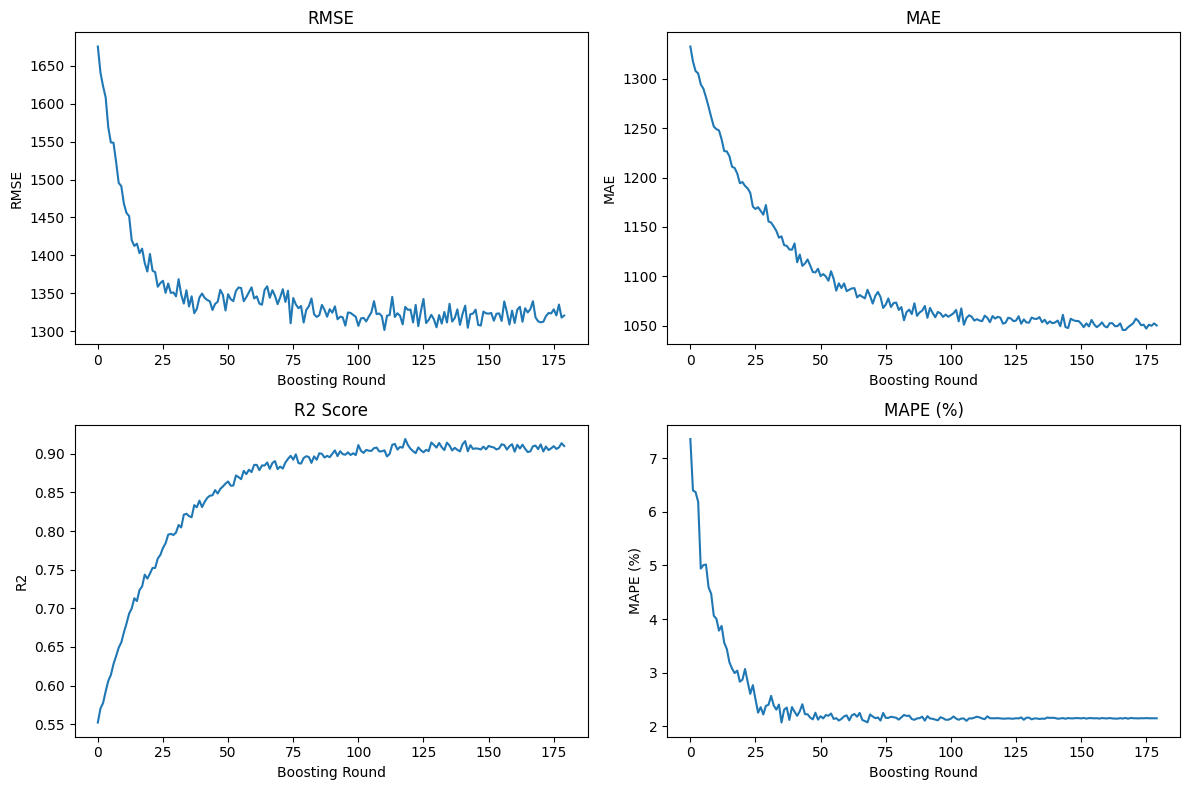

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

results = bst.evals_result()

val_rmse = results["eval"]["rmse"]

rounds = len(val_rmse)
x = np.arange(rounds)

val_mae = []
val_r2 = []
val_mape = []

y_val_salary = np.expm1(y_val)

for i in range(rounds):
    preds_iter = bst.predict(dval, iteration_range=(0, i+1))
    preds_salary = np.expm1(preds_iter)
    
    val_mae.append(mean_absolute_error(y_val_salary, preds_salary))
    val_r2.append(r2_score(y_val_salary, preds_salary))
    val_mape.append(
        np.mean(np.abs((y_val_salary - preds_salary) / y_val_salary)) * 100
    )

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

metrics = [
    ("RMSE", val_rmse),
    ("MAE", val_mae),
    ("R²", val_r2),
    ("MAPE", val_mape),
]

for ax, (title, values) in zip(axs.flatten(), metrics):
    ax.plot(x, values)
    ax.set_title(title)
    ax.set_xlabel("Boosting Round")
    ax.set_ylabel("Metric Value")

plt.tight_layout()
plt.show()